In [67]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chi2

dose_data = pd.read_csv('newtonmethod.csv')  
x_dose = dose_data['xaxis1'] 
y_effectiveness = dose_data['yaxis1']  

time_data = pd.read_csv('newtonmethod.csv')  
x_time = time_data['xaxis2']  
y_concentration = time_data['yaxis2'] 

def linear(x, a, b):
    return a * x + b
def logarithmic(x, a, b):
    return a * np.log(x) + b
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c
def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d
def hyperbola(x, a, b):
    return a * x / (x + b)
def exponential(x, a, b):
    return a * np.exp(-b * x)

functions = {
    "Linear": linear,
    "Logarithmic": logarithmic,
    "Quadratic": quadratic,
    "Cubic": cubic,
    "Hyperbola": hyperbola,
    "Exponential": exponential
}

In [ ]:
def fit_data(x_data, y_data, label):
    results = []
    for name, func in functions.items():
        try:
            params, _ = curve_fit(func, x_data, y_data)
            residuals = y_data - func(x_data, *params)
            rss = np.sum(residuals ** 2)

            n = len(y_data)
            p = len(params)
            p_value = 1 - chi2.cdf(rss, n - p)

            results.append((name, params, rss, p_value))
        except Exception as e:
            print(f"Could not fit {name} function for {label}: {e}")

    print(f"Results for {label} data:")
    for result in results:
        name, params, rss, p_value = result
        coef_str = ", ".join([f"{param:.5f}" for param in params])
        print(f"Function: {name}, Coefficients: [{coef_str}], RSS: {rss:.5f}, p-value: {p_value:.5f}")
    print("\n")

    return results
    
alfentanil_results = fit_data(x_dose, y_effectiveness, "Alfentanil dose-effectiveness")
quinidine_results = fit_data(x_time, y_concentration, "Quinidine time-concentration")

Results for Alfentanil dose-effectiveness data:
Function: Linear, Coefficients: [0.12393, 0.22219], RSS: 0.03637, p-value: 1.00000
Function: Logarithmic, Coefficients: [0.07988, 0.35669], RSS: 0.02475, p-value: 1.00000
Function: Quadratic, Coefficients: [-0.16831, 0.39322, 0.14589], RSS: 0.02468, p-value: 1.00000
Function: Cubic, Coefficients: [0.17932, -0.59868, 0.67762, 0.10199], RSS: 0.02284, p-value: 1.00000
Function: Hyperbola, Coefficients: [0.42116, 0.17570], RSS: 0.02344, p-value: 1.00000
Function: Exponential, Coefficients: [0.23892, -0.35684], RSS: 0.03958, p-value: 1.00000


Results for Quinidine time-concentration data:
Function: Linear, Coefficients: [-0.13143, 0.39114], RSS: 0.02919, p-value: 1.00000
Function: Logarithmic, Coefficients: [-0.07727, 0.25180], RSS: 0.02645, p-value: 1.00000
Function: Quadratic, Coefficients: [0.07466, -0.25089, 0.42499], RSS: 0.02689, p-value: 1.00000
Function: Cubic, Coefficients: [-0.27631, 0.73781, -0.68912, 0.49263], RSS: 0.02252, p-valu

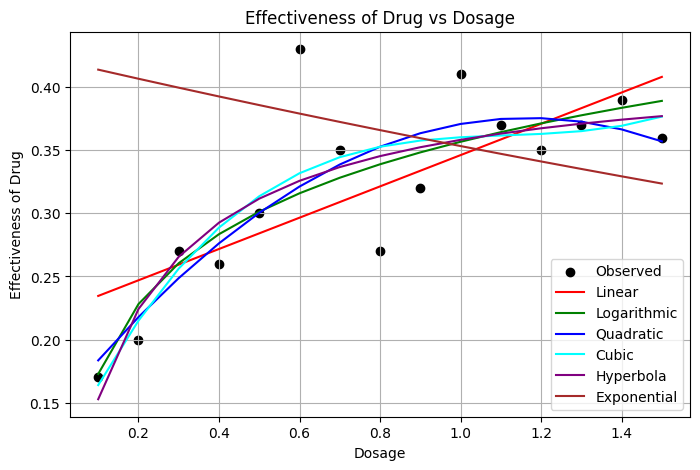

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(x_dose, y_effectiveness, color='black', marker='o', label="Observed")

params_linear, _ = curve_fit(linear, x_dose, y_effectiveness)
plt.plot(x_dose, linear(x_dose, *params_linear), label="Linear", linestyle='-', color='red')

params_log, _ = curve_fit(logarithmic, x_dose, y_effectiveness)
plt.plot(x_dose, logarithmic(x_dose, *params_log), label="Logarithmic", linestyle='-', color='green')

params_quad, _ = curve_fit(quadratic, x_dose, y_effectiveness)
plt.plot(x_dose, quadratic(x_dose, *params_quad), label="Quadratic", linestyle='-', color='blue')

params_cubic, _ = curve_fit(cubic, x_dose, y_effectiveness)
plt.plot(x_dose, cubic(x_dose, *params_cubic), label="Cubic", linestyle='-', color='cyan')

params_hyperbolic, _ = curve_fit(hyperbola, x_dose, y_effectiveness)
plt.plot(x_dose, hyperbola(x_dose, *params_hyperbolic), label="Hyperbola", linestyle='-', color='purple')

params_exp, _ = curve_fit(exponential, x_dose, y_effectiveness)
plt.plot(x_dose, exponential(x_dose, *params_hyperbolic), label="Exponential", linestyle='-', color='brown')

plt.xlabel("Dosage")
plt.ylabel("Effectiveness of Drug")
plt.title("Effectiveness of Drug vs Dosage")
plt.legend()
plt.grid(True)
plt.show()


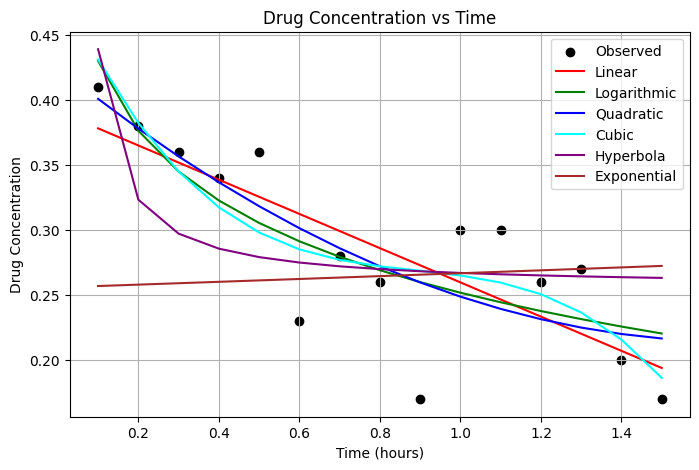

In [77]:
plt.figure(figsize=(8, 5))
plt.scatter(x_time, y_concentration, color='black', marker='o', label="Observed")

params_linear, _ = curve_fit(linear, x_time, y_concentration)
plt.plot(x_time, linear(x_time, *params_linear), label="Linear", linestyle='-', color='red')

params_log, _ = curve_fit(logarithmic, x_time, y_concentration)
plt.plot(x_time, logarithmic(x_time, *params_log), label="Logarithmic", linestyle='-', color='green')

params_quad, _ = curve_fit(quadratic, x_time, y_concentration)
plt.plot(x_time, quadratic(x_time, *params_quad), label="Quadratic", linestyle='-', color='blue')

params_cubic, _ = curve_fit(cubic, x_time, y_concentration)
plt.plot(x_time, cubic(x_time, *params_cubic), label="Cubic", linestyle='-', color='cyan')

params_hyperbolic, _ = curve_fit(hyperbola, x_time, y_concentration)
plt.plot(x_time, hyperbola(x_time, *params_hyperbolic), label="Hyperbola", linestyle='-', color='purple')

params_exp, _ = curve_fit(exponential, x_time, y_concentration)
plt.plot(x_time, exponential(x_time, *params_hyperbolic), label="Exponential", linestyle='-', color='brown')

plt.xlabel("Time (hours)")
plt.ylabel("Drug Concentration")
plt.title("Drug Concentration vs Time")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
def display_best_model(results, label):
    best_model = min(results, key=lambda x: x[2]) 
    name, params, rss, p_value = best_model

    print(f"Best Model fot {label} Study : {name} Model")
    print(f"Parameters: a = {params[0]:.5f}, b = {params[1]:.5f}")
    print(f"RSS: {rss:.5f}, p-value: {p_value:.5f}\n")
    
display_best_model(alfentanil_results, "Dose-Effectiveness")
display_best_model(quinidine_results, "Time-Concentration")

Best Model fot Dose-Effectiveness Study : Cubic Model
Parameters: a = 0.17932, b = -0.59868
RSS: 0.02284, p-value: 1.00000

Best Model fot Time-Concentration Study : Cubic Model
Parameters: a = -0.27631, b = 0.73781
RSS: 0.02252, p-value: 1.00000



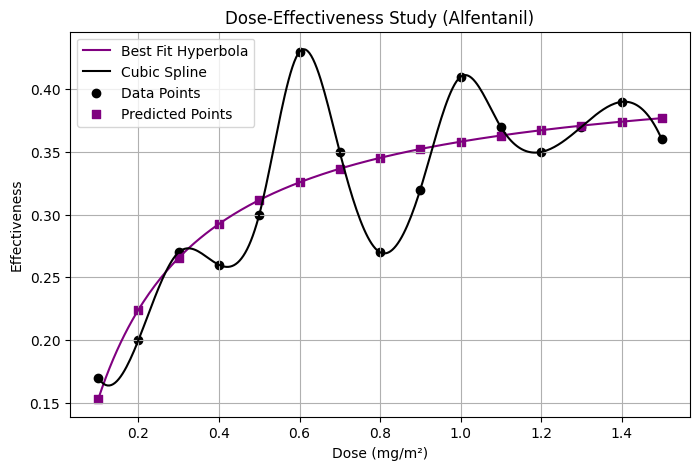

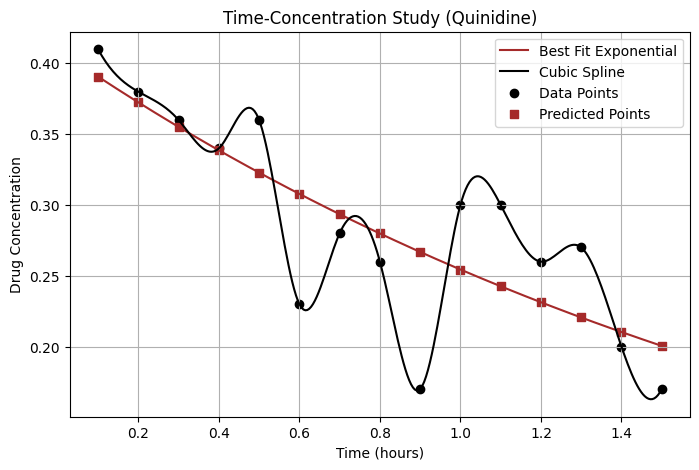

In [72]:
from scipy.interpolate import make_interp_spline

def hyperbola(x, a, b):
    return a * x / (x + b)

params_hyperbola, _ = curve_fit(hyperbola, x_dose, y_effectiveness)
params_exponential, _ = curve_fit(exponential, x_time, y_concentration)

x_dose_smooth = np.linspace(x_dose.min(), x_dose.max(), 300)
x_time_smooth = np.linspace(x_time.min(), x_time.max(), 300)

predicted_effectiveness = hyperbola(x_dose, *params_hyperbola)
predicted_concentration = exponential(x_time, *params_exponential)

spline_effectiveness = make_interp_spline(x_dose, y_effectiveness)(x_dose_smooth)
spline_concentration = make_interp_spline(x_time, y_concentration)(x_time_smooth)

plt.figure(figsize=(8, 5))
plt.plot(x_dose_smooth, hyperbola(x_dose_smooth, *params_hyperbola), label="Best Fit Hyperbola", color='purple')
plt.plot(x_dose_smooth, spline_effectiveness, label="Cubic Spline", color='black')
plt.scatter(x_dose, y_effectiveness, color='black', marker='o', label="Data Points")  
plt.scatter(x_dose, predicted_effectiveness, color='purple', marker='s', label="Predicted Points")  
plt.xlabel("Dose (mg/m²)")
plt.ylabel("Effectiveness")
plt.title("Dose-Effectiveness Study (Alfentanil)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(x_time_smooth, exponential(x_time_smooth, *params_exponential), label="Best Fit Exponential", color='brown')
plt.plot(x_time_smooth, spline_concentration, label="Cubic Spline", color='black')
plt.scatter(x_time, y_concentration, color='black', marker='o', label="Data Points")  
plt.scatter(x_time, predicted_concentration, color='brown', marker='s', label="Predicted Points")  
plt.xlabel("Time (hours)")
plt.ylabel("Drug Concentration")
plt.title("Time-Concentration Study (Quinidine)")
plt.legend()
plt.grid(True)
plt.show()


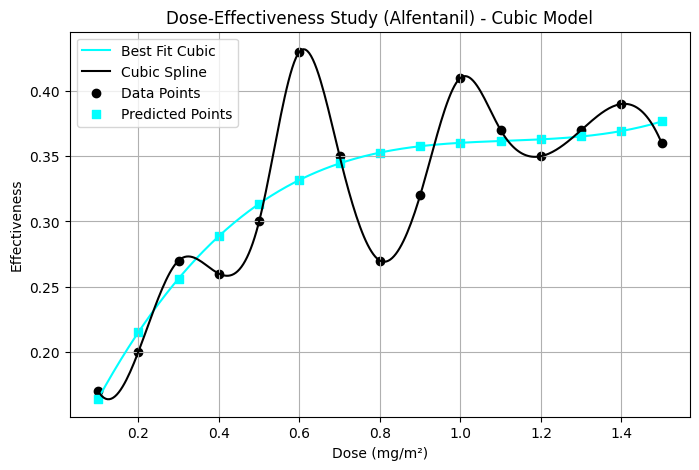

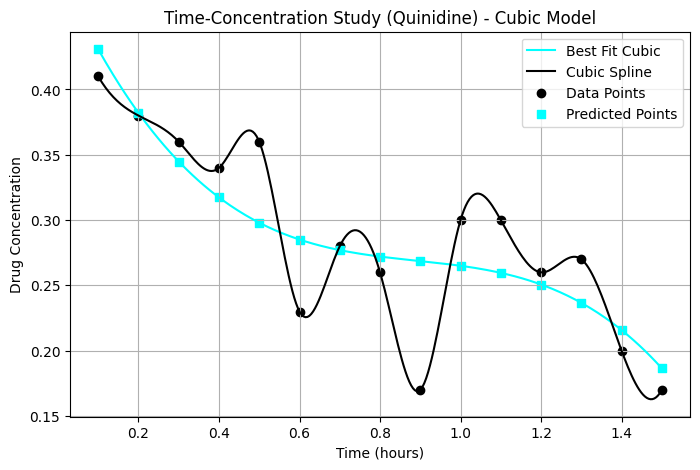

In [73]:

def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

params_cubic_dose, _ = curve_fit(cubic, x_dose, y_effectiveness)
params_cubic_time, _ = curve_fit(cubic, x_time, y_concentration)

x_dose_smooth = np.linspace(x_dose.min(), x_dose.max(), 300)
x_time_smooth = np.linspace(x_time.min(), x_time.max(), 300)

predicted_effectiveness = cubic(x_dose, *params_cubic_dose)
predicted_concentration = cubic(x_time, *params_cubic_time)

spline_effectiveness = make_interp_spline(x_dose, y_effectiveness)(x_dose_smooth)
spline_concentration = make_interp_spline(x_time, y_concentration)(x_time_smooth)

plt.figure(figsize=(8, 5))
plt.plot(x_dose_smooth, cubic(x_dose_smooth, *params_cubic_dose), label="Best Fit Cubic", color='cyan')
plt.plot(x_dose_smooth, spline_effectiveness, label="Cubic Spline", color='black')
plt.scatter(x_dose, y_effectiveness, color='black', marker='o', label="Data Points") 
plt.scatter(x_dose, predicted_effectiveness, color='cyan', marker='s', label="Predicted Points")
plt.xlabel("Dose (mg/m²)")
plt.ylabel("Effectiveness")
plt.title("Dose-Effectiveness Study (Alfentanil) - Cubic Model")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(x_time_smooth, cubic(x_time_smooth, *params_cubic_time), label="Best Fit Cubic", color='cyan')
plt.plot(x_time_smooth, spline_concentration, label="Cubic Spline", color='black')
plt.scatter(x_time, y_concentration, color='black', marker='o', label="Data Points")  
plt.scatter(x_time, predicted_concentration, color='cyan', marker='s', label="Predicted Points")  
plt.xlabel("Time (hours)")
plt.ylabel("Drug Concentration")
plt.title("Time-Concentration Study (Quinidine) - Cubic Model")
plt.legend()
plt.grid(True)
plt.show()
